In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random
import tensorflow as tf
%matplotlib inline

# LSTM, BI-LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from keras._tf_keras.keras.callbacks import EarlyStopping, ModelCheckpoint

# Random Forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

2024-08-19 10:18:20.343595: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-19 10:18:20.568628: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-19 10:18:21.447554: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 10:18:24.894508: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv('./data/dataset.csv')
df.head()

,Date,Open,Close,10YR Open Price,ADA Open Price,BNB Open Price,BTC Fear Greed Index,"BTC / Fees, total, USD","BTC / Supply, Miner, held by all mining entities, USD","BTC / Miner revenue, USD",...,DXY Open Price,ETH Open Price,GOLD Open Price,MATIC Open Price,NASDAQ Open Price,NIKKEI225 Open Price,OIL Open Price,S&P500 Open Price,SILVER Open Price,SOL Open Price
0,2014-09-18,456.859985,424.440002,2.625,0.02516,2.05314,30,5494.516757,922278182.1,2127475.011,...,94.879997,308.644989,1216.199951,0.004521,4575.740234,16036.469727,93.970001,2003.069946,18.475000,0.832005
1,2014-09-19,424.102997,394.795990,2.611,0.02516,2.05314,30,5214.342615,863041567.8,1915502.821,...,94.879997,308.644989,1218.300049,0.004521,4606.129883,16177.940430,92.970001,2012.739990,18.295000,0.832005
2,2014-09-20,394.673004,408.903992,2.611,0.02516,2.05314,30,4261.732292,796896261.3,1688158.115,...,94.879997,308.644989,1218.300049,0.004521,4606.129883,16177.940430,92.970001,2012.739990,18.295000,0.832005
3,2014-09-21,408.084991,398.821014,2.611,0.02516,2.05314,30,4235.264753,832455744.7,1812817.173,...,94.879997,308.644989,1218.300049,0.004521,4606.129883,16177.940430,92.970001,2012.739990,18.295000,0.832005
4,2014-09-22,399.100006,402.152008,2.562,0.02516,2.05314,30,3638.427361,811705344.8,1645297.003,...,94.879997,308.644989,1214.900024,0.004521,4568.450195,16281.360352,92.220001,2009.079956,17.700001,0.832005


**RF**


In [3]:
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

X = df.drop(['Date', 'Close', 'Google BTC Trend'], axis=1)
y = df['Close']

rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(
    X, y, test_size=0.15, shuffle=False)

# model
rfr = RandomForestRegressor(random_state=seed_value, criterion='absolute_error', n_estimators=500)
rfr.fit(rf_X_train, rf_y_train)
rfr_pred = rfr.predict(rf_X_test)

In [4]:
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

X = df.drop(['Date', 'Close', 'Google BTC Trend'], axis=1)
y = df['Close']

scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.values.reshape(-1, 1))

train_size = int(len(df) * 0.7)
validation_size = int((len(df) - train_size) / 2) 

train_X, validation_X = X[0:train_size,:], X[train_size:train_size+validation_size,:]
train_y, validation_y = y[0:train_size,:], y[train_size:train_size+validation_size,:]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
validation_X = validation_X.reshape((validation_X.shape[0], 1, validation_X.shape[1]))

**LSTM**


In [5]:
lstm_model = Sequential()
lstm_model.add(LSTM(256, return_sequences=True, activation='relu',input_shape=(train_X.shape[1], train_X.shape[2])))
lstm_model.add(LSTM(128,  activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_absolute_error')


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.keras', save_best_only=True, monitor='val_loss')

lstm_model.fit(train_X, train_y, epochs=100, batch_size=16,validation_data=(validation_X, validation_y),
          verbose=2, callbacks=[early_stopping, model_checkpoint])

/home/zhizhan/workspace/defifolio/models/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
155/155 - 9s - 57ms/step - loss: 0.0254 - val_loss: 0.0286
Epoch 2/100
155/155 - 2s - 11ms/step - loss: 0.0081 - val_loss: 0.0231
Epoch 3/100
155/155 - 2s - 15ms/step - loss: 0.0068 - val_loss: 0.0234
Epoch 4/100
155/155 - 2s - 15ms/step - loss: 0.0061 - val_loss: 0.0235
Epoch 5/100
155/155 - 2s - 15ms/step - loss: 0.0057 - val_loss: 0.0232
Epoch 6/100
155/155 - 2s - 16ms/step - loss: 0.0052 - val_loss: 0.0163
Epoch 7/100
155/155 - 2s - 15ms/step - loss: 0.0052 - val_loss: 0.0156
Epoch 8/100
155/155 - 2s - 15ms/step - loss: 0.0051 - val_loss: 0.0160
Epoch 9/100
155/155 - 2s - 15ms/step - loss: 0.0052 - val_loss: 0.0137
Epoch 10/100
155/155 - 2s - 15ms/step - loss: 0.0049 - val_loss: 0.0150
Epoch 11/100
155/155 - 2s - 15ms/step - loss: 0.0045 - val_loss: 0.0131
Epoch 12/100
155/155 - 2s - 15ms/step - loss: 0.0045 - val_loss: 0.0156
Epoch 13/100
155/155 - 2s - 15ms/step - loss: 0.0045 - val_loss: 0.0175
Epoch 14/100
155/155 - 2s - 15ms/step - loss: 0.0046 - val_loss: 0.0213
E

**Bi-LSTM**


In [6]:
bi_lstm_model = Sequential()
bi_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True, activation='relu',input_shape=(train_X.shape[1], train_X.shape[2]))))
bi_lstm_model.add(Bidirectional(LSTM(128,  activation='relu')))
bi_lstm_model.add(Dense(1))
bi_lstm_model.compile(optimizer='adam', loss='mean_absolute_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_bi_lstm_model.keras', save_best_only=True, monitor='val_loss')

bi_lstm_model.fit(train_X, train_y, epochs=100, batch_size=16,validation_data=(validation_X, validation_y),
          verbose=2, callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
155/155 - 16s - 105ms/step - loss: 0.0211 - val_loss: 0.0421
Epoch 2/100
155/155 - 4s - 24ms/step - loss: 0.0083 - val_loss: 0.0217
Epoch 3/100
155/155 - 3s - 18ms/step - loss: 0.0065 - val_loss: 0.0261
Epoch 4/100
155/155 - 3s - 17ms/step - loss: 0.0056 - val_loss: 0.0162
Epoch 5/100
155/155 - 3s - 18ms/step - loss: 0.0062 - val_loss: 0.0406
Epoch 6/100
155/155 - 2s - 16ms/step - loss: 0.0059 - val_loss: 0.0291
Epoch 7/100
155/155 - 3s - 17ms/step - loss: 0.0059 - val_loss: 0.0134
Epoch 8/100
155/155 - 3s - 22ms/step - loss: 0.0053 - val_loss: 0.0256
Epoch 9/100
155/155 - 3s - 21ms/step - loss: 0.0049 - val_loss: 0.0319
Epoch 10/100
155/155 - 3s - 22ms/step - loss: 0.0050 - val_loss: 0.0217
Epoch 11/100
155/155 - 2s - 16ms/step - loss: 0.0056 - val_loss: 0.0152
Epoch 12/100
155/155 - 2s - 15ms/step - loss: 0.0044 - val_loss: 0.0181
Epoch 13/100
155/155 - 2s - 15ms/step - loss: 0.0048 - val_loss: 0.0256
Epoch 14/100
155/155 - 2s - 15ms/step - loss: 0.0044 - val_loss: 0.0150

In [7]:
df_test = pd.DataFrame()
df_test['Date'] = pd.to_datetime(df['Date'][train_size+validation_size:len(df)])

# calculate macd using 12 and 26 days
df_macd = df.copy()
df_macd = df_macd[['Date', 'Open']]
# convert the date to datetime
df_macd['Date'] = pd.to_datetime(df_macd['Date'])
df_macd['EMA12'] = df_macd['Open'].ewm(span=12, adjust=False).mean()
df_macd['EMA26'] = df_macd['Open'].ewm(span=26, adjust=False).mean()
df_macd['MACD'] = df_macd['EMA12'] - df_macd['EMA26']
df_macd['Signal'] = df_macd['MACD'].ewm(span=9, adjust=False).mean()
df_macd['MACD_Hist'] = df_macd['MACD'] - df_macd['Signal']
df_macd['MACD_Signal_Ratio'] = df_macd['MACD'] / df_macd['Signal']
df_macd['MACD_Crossover'] = 0
df_macd.loc[(df_macd['MACD'] > df_macd['Signal']) & (df_macd['MACD'].shift(1) < df_macd['Signal'].shift(1)), 'MACD_Crossover'] = 1  # Bullish crossover
df_macd.loc[(df_macd['MACD'] < df_macd['Signal']) & (df_macd['MACD'].shift(1) > df_macd['Signal'].shift(1)), 'MACD_Crossover'] = -1 # Bearish crossover
df_macd = df_macd[df_macd['Date'] >= df_test['Date'].iloc[0]]

df_test['MACD_Signal_Ratio'] = df_macd['MACD_Signal_Ratio'].values
df_test['MACD_Crossover'] = df_macd['MACD_Crossover'].values
df_test

,Date,MACD_Signal_Ratio,MACD_Crossover
3004,2022-12-09,0.537999,0
3005,2022-12-10,0.508967,0
3006,2022-12-11,0.485164,0
3007,2022-12-12,0.472633,0
3008,2022-12-13,0.426570,0
...,...,...,...
3530,2024-05-19,-1.015114,0
3531,2024-05-20,-2.665683,0
3532,2024-05-21,19.791178,0
3533,2024-05-22,4.318177,0


In [8]:
# predict using model with df_test_dates
test_X = X[train_size+validation_size:len(df),:]
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
prediction = lstm_model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_test_prediction = np.concatenate((prediction, test_X[:, 1:]), axis=1)
inv_test_prediction = scaler.inverse_transform(inv_test_prediction)
inv_test_prediction = inv_test_prediction[:,0]
df_test['LSTM Predicted Price'] = inv_test_prediction

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


In [9]:
# predict using model with df_test_dates
test_X = X[train_size+validation_size:len(df),:]
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
prediction = bi_lstm_model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_test_prediction = np.concatenate((prediction, test_X[:, 1:]), axis=1)
inv_test_prediction = scaler.inverse_transform(inv_test_prediction)
inv_test_prediction = inv_test_prediction[:,0]
df_test['Bi-LSTM Predicted Price'] = inv_test_prediction

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


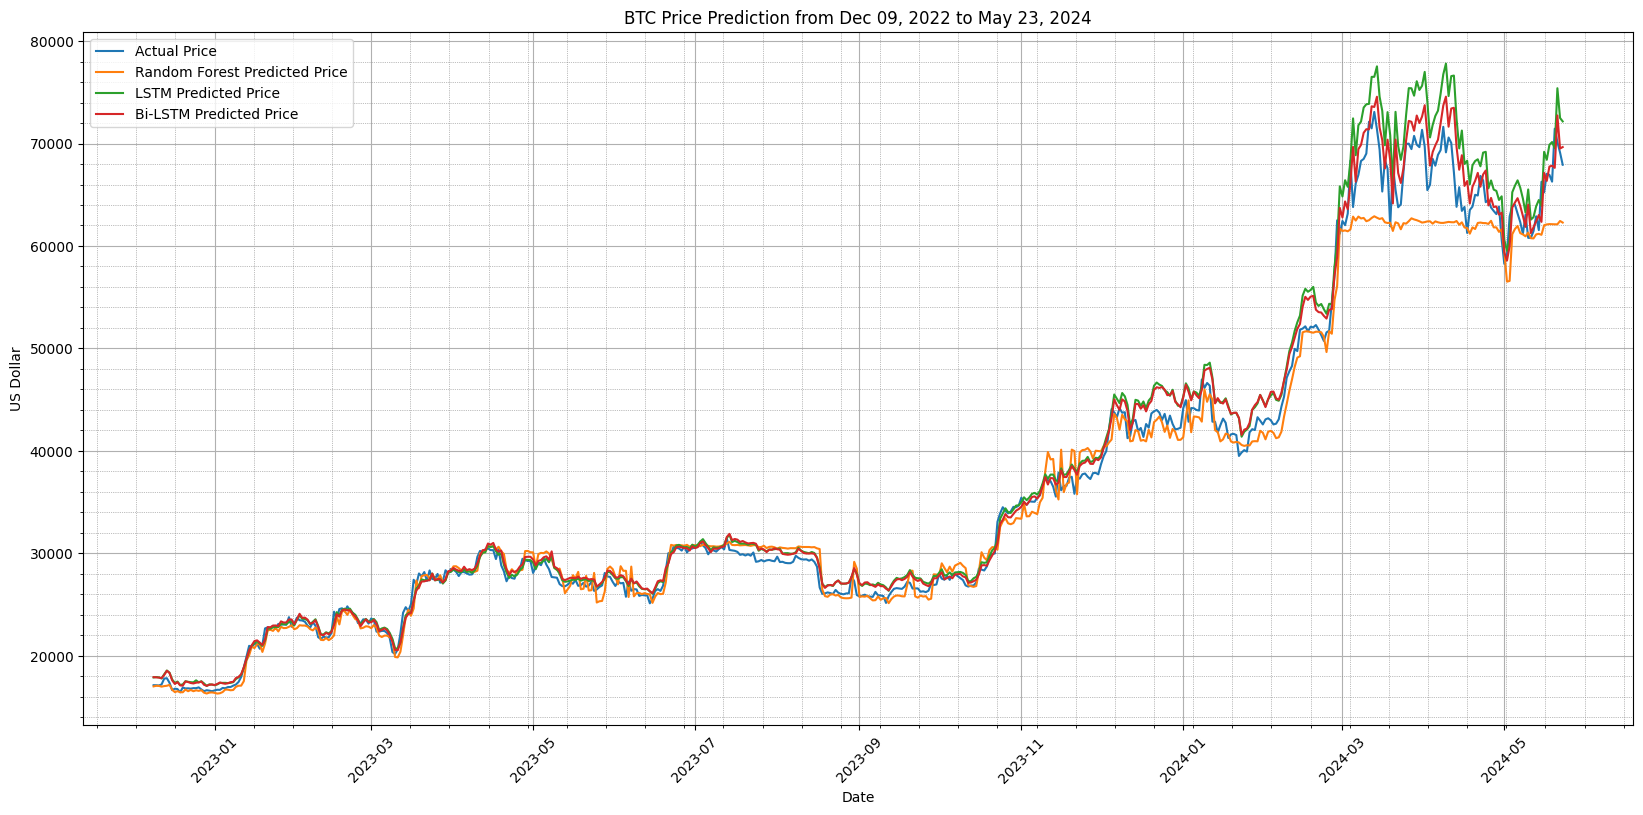

In [10]:
plt.figure(figsize=(20, 9))
plt.plot(df_test['Date'], df['Close'][train_size+validation_size:len(df)], label='Actual Price')
plt.plot(df_test['Date'], rfr_pred, label='Random Forest Predicted Price')
plt.plot(df_test['Date'], df_test['LSTM Predicted Price'], label='LSTM Predicted Price')
plt.plot(df_test['Date'], df_test['Bi-LSTM Predicted Price'], label='Bi-LSTM Predicted Price')

plt.title('BTC Price Prediction from Dec 09, 2022 to May 23, 2024')

plt.ylabel('US Dollar')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()

plt.gca().yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.gca().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())

plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)
plt.grid(which='major')

plt.show()

In [11]:
# print mae, rmse, r2 score of each model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print('Random Forest')
print('MAE:', mean_absolute_error(df['Close'][train_size+validation_size:len(df)], rfr_pred))
print('RMSE:', np.sqrt(mean_squared_error(df['Close'][train_size+validation_size:len(df)], rfr_pred)))
print('R2 Score:', r2_score(df['Close'][train_size+validation_size:len(df)], rfr_pred))
print('MAPE:', np.mean(np.abs((df['Close'][train_size+validation_size:len(df)] - rfr_pred) / df['Close'][train_size+validation_size:len(df)])))

print('\nLSTM') 
print('MAE:', mean_absolute_error(df['Close'][train_size+validation_size:len(df)], df_test['LSTM Predicted Price']))
print('RMSE:', np.sqrt(mean_squared_error(df['Close'][train_size+validation_size:len(df)], df_test['LSTM Predicted Price'])))
print('R2 Score:', r2_score(df['Close'][train_size+validation_size:len(df)], df_test['LSTM Predicted Price']))
print('MAPE:', np.mean(np.abs((df['Close'][train_size+validation_size:len(df)] - df_test['LSTM Predicted Price']) / df['Close'][train_size+validation_size:len(df)])))

print('\nBi-LSTM') 
print('MAE:', mean_absolute_error(df['Close'][train_size+validation_size:len(df)], df_test['Bi-LSTM Predicted Price']))
print('RMSE:', np.sqrt(mean_squared_error(df['Close'][train_size+validation_size:len(df)], df_test['Bi-LSTM Predicted Price'])))
print('R2 Score:', r2_score(df['Close'][train_size+validation_size:len(df)], df_test['Bi-LSTM Predicted Price']))
print('MAPE:', np.mean(np.abs((df['Close'][train_size+validation_size:len(df)] - df_test['Bi-LSTM Predicted Price']) / df['Close'][train_size+validation_size:len(df)])))


Random Forest
MAE: 1417.3212778194616
RMSE: 2304.6227293777306
R2 Score: 0.9773496567548605
MAPE: 0.03352847768444588

LSTM
MAE: 1418.1414066314248
RMSE: 2160.3648466957206
R2 Score: 0.980096506567804
MAPE: 0.03346933297729202

Bi-LSTM
MAE: 1074.495791278737
RMSE: 1500.8270646126869
R2 Score: 0.9903941364840826
MAPE: 0.02804077910819191


In [12]:
import pickle

lstm_model.save('./lstm_model.h5')
bi_lstm_model.save('./bi_lstm_model.h5')

with open('./random_forest_model.pkl', 'wb') as f:
    pickle.dump(rfr, f)

**$50 dollars**


RF Total Trades: 54 ,RF Win Trades: 24 ,RF Loss Trades: 30 ,RF Win Ratio: 0.4444444444444444 ,RF Loss Ratio: 0.5555555555555556 ,RF Win/Loss Ratio: 0.8
LSTM Total Trades: 45 ,LSTM Win Trades: 34 ,LSTM Loss Trades: 11 ,LSTM Win Ratio: 0.7555555555555555 ,LSTM Loss Ratio: 0.24444444444444446 ,LSTM Win/Loss Ratio: 3.090909090909091
Bi-LSTM Total Trades: 47 ,Bi-LSTM Win Trades: 31 ,Bi-LSTM Loss Trades: 16 ,Bi-LSTM Win Ratio: 0.6595744680851063 ,Bi-LSTM Loss Ratio: 0.34042553191489366 ,Bi-LSTM Win/Loss Ratio: 1.9375
MACD CROSS RF Total Trades: 8 ,MACD CROSS RF Win Trades: 2 ,MACD CROSS RF Loss Trades: 6 ,MACD CROSS RF Win Ratio: 0.25 ,MACD CROSS RF Loss Ratio: 0.75 ,MACD CROSS RF Win/Loss Ratio: 0.3333333333333333
MACD CROSS LSTM Total Trades: 5 ,MACD CROSS LSTM Win Trades: 2 ,MACD CROSS LSTM Loss Trades: 3 ,MACD CROSS LSTM Win Ratio: 0.4 ,MACD CROSS LSTM Loss Ratio: 0.6 ,MACD CROSS LSTM Win/Loss Ratio: 0.6666666666666666
MACD CROSS Bi-LSTM Total Trades: 5 ,MACD CROSS Bi-LSTM Win Trades: 1 

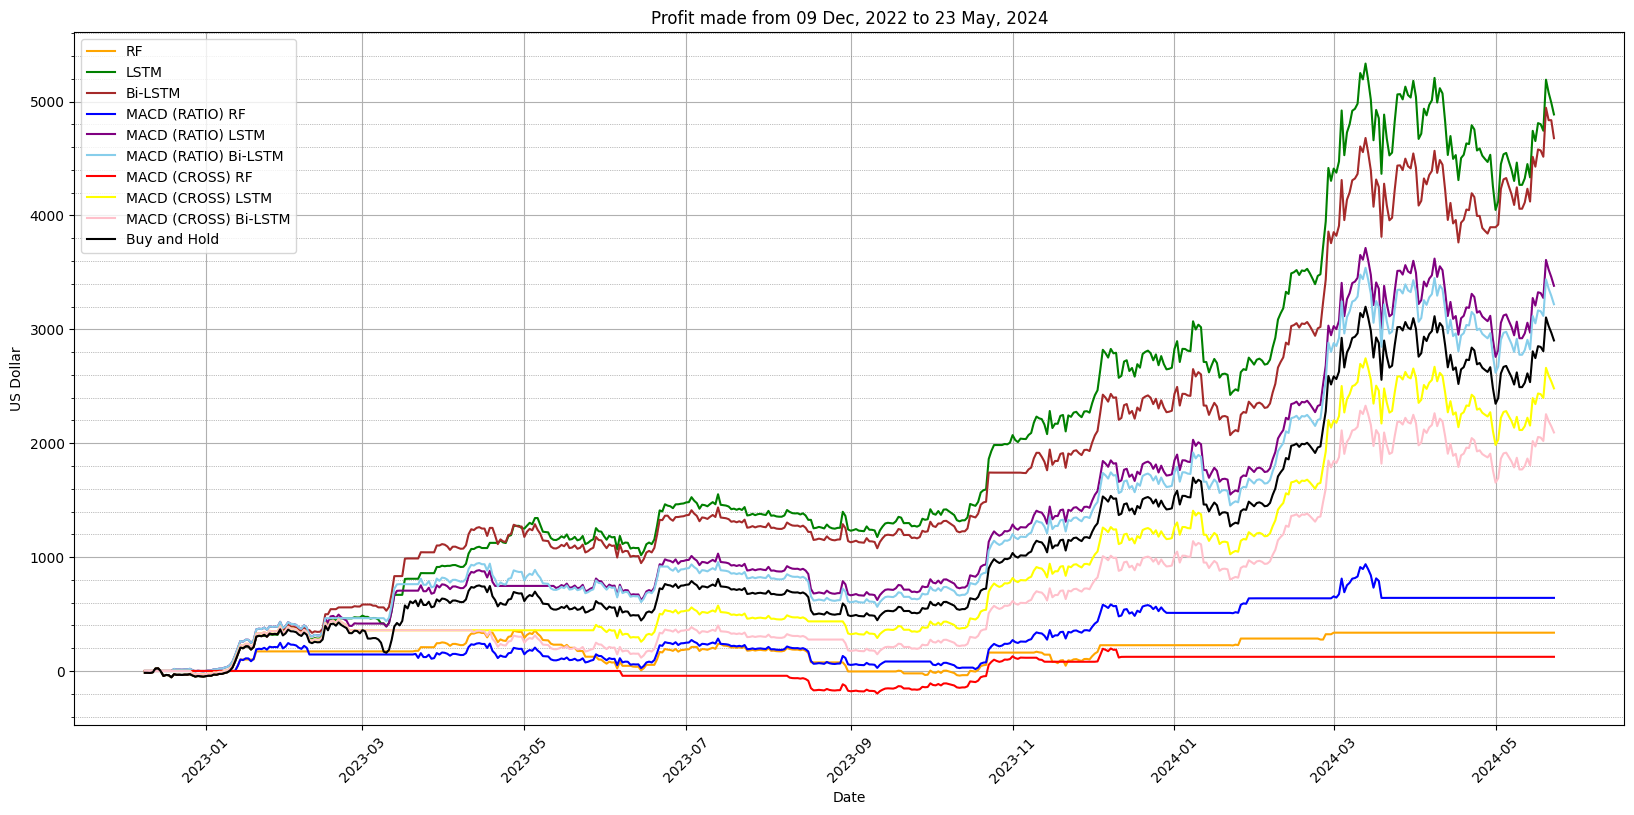

In [13]:
# convert to dictionary
df_calculate = pd.DataFrame()
df_calculate['Date'] = df_test['Date']
df_calculate['Open'] = df['Open']
df_calculate['Actual Close'] = df['Close'][train_size+validation_size:len(df)]
df_calculate['RF Predicted Close'] = rfr_pred
df_calculate['LSTM Predicted Close'] = df_test['LSTM Predicted Price']
df_calculate['Bi-LSTM Predicted Close'] = df_test['Bi-LSTM Predicted Price']
df_calculate['MACD_Signal_Ratio'] = df_test['MACD_Signal_Ratio']
df_calculate['MACD_Crossover'] = df_test['MACD_Crossover']

d = df_calculate.to_dict('records')

inital_shares = 1000.0/ d[0]['Open'] * 0.995
peak_value = 1000
trough_value  = 1000

rf_cash = 1000.0
rf_shares = 0
rf_total_trades = 0
rf_win_trades = 0
rf_peak_value= 1000
rf_trough_value = 1000

lstm_cash = 1000.0
lstm_shares = 0
lstm_total_trades = 0
lstm_win_trades = 0
lstm_peak_value = 1000
lstm_trough_value = 1000

bi_lstm_cash = 1000.0
bi_lstm_shares = 0
bi_lstm_total_trades = 0
bi_lstm_win_trades = 0
bi_lstm_peak_value = 1000
bi_lstm_trough_value = 1000


macd_ratio_rf_cash = 1000.0
macd_ratio_rf_shares = 0
macd_ratio_rf_total_trades = 0
macd_ratio_rf_win_trades = 0
macd_ratio_rf_peak_value = 1000
macd_ratio_rf_trough_value = 1000

macd_ratio_lstm_cash = 1000.0
macd_ratio_lstm_shares = 0
macd_ratio_lstm_total_trades = 0
macd_ratio_lstm_win_trades = 0
macd_ratio_lstm_peak_value = 1000
macd_ratio_lstm_trough_value = 1000

macd_ratio_bi_lstm_cash = 1000.0
macd_ratio_bi_lstm_shares = 0
macd_ratio_bi_lstm_total_trades = 0
macd_ratio_bi_lstm_win_trades = 0
macd_ratio_bi_lstm_peak_value = 1000
macd_ratio_bi_lstm_trough_value = 1000


# MACD Calculation
macd_crossover = 0

macd_cross_rf_cash = 1000.0
macd_cross_rf_shares = 0
macd_cross_rf_total_trades = 0
macd_cross_rf_win_trades = 0
macd_cross_rf_peak_value = 1000
macd_cross_rf_trough_value = 1000

macd_cross_lstm_cash = 1000.0
macd_cross_lstm_shares = 0
macd_cross_lstm_total_trades = 0
macd_cross_lstm_win_trades = 0
macd_cross_lstm_peak_value = 1000
macd_cross_lstm_trough_value = 1000

macd_cross_bi_lstm_cash = 1000.0
macd_cross_bi_lstm_shares = 0
macd_cross_bi_lstm_total_trades = 0
macd_cross_bi_lstm_win_trades = 0
macd_cross_bi_lstm_peak_value = 1000
macd_cross_bi_lstm_trough_value = 1000


daily_reports = []
monthly_reports = []

# Loop through each day, skip first day
for i in range(0, len(d)):
    data = d[i]

    rf_price_change = data['RF Predicted Close'] - data['Open']
    if rf_price_change > 50 and rf_cash > 0:
        rf_shares = (rf_cash / data['Open']) * 0.995
        rf_cash = 0
        rf_total_trades += 1
        if data['Actual Close'] * 0.995 > data['Open']:
            rf_win_trades += 1
    elif rf_price_change < -50 and rf_shares > 0:
        rf_cash = rf_shares * data['Open'] * 0.995
        rf_shares = 0
        rf_total_trades += 1
        if data['Actual Close'] < data['Open'] * 0.995:
            rf_win_trades += 1

    lstm_price_change = data['LSTM Predicted Close'] - data['Open']
    if lstm_price_change > 50 and lstm_cash > 0:
        lstm_shares = (lstm_cash / data['Open']) * 0.995
        lstm_cash = 0
        lstm_total_trades += 1
        if data['Actual Close'] * 0.995 > data['Open']:
            lstm_win_trades += 1
    elif lstm_price_change < -50 and lstm_shares > 0:
        lstm_cash = lstm_shares * data['Open'] * 0.995 
        lstm_shares = 0
        lstm_total_trades += 1
        if data['Actual Close'] < data['Open'] * 0.995:
            lstm_win_trades += 1

    bi_lstm_price_change = data['Bi-LSTM Predicted Close'] - data['Open']
    # if price change is positive, buy shares
    if bi_lstm_price_change > 50 and bi_lstm_cash > 0:
        bi_lstm_shares = (bi_lstm_cash / data['Open']) * 0.995
        bi_lstm_cash = 0
        bi_lstm_total_trades += 1
        if data['Actual Close'] * 0.995 > data['Open']:
            bi_lstm_win_trades += 1
    elif bi_lstm_price_change < -50 and bi_lstm_shares > 0:
        bi_lstm_cash = bi_lstm_shares * data['Open'] * 0.995 # 0.3% trading fee and 0.2% slippage
        bi_lstm_shares = 0
        bi_lstm_total_trades += 1
        if data['Actual Close'] < data['Open'] * 0.995:
            bi_lstm_win_trades += 1


    # MACD Crossover
    macd_crossover = data['MACD_Crossover']
    if macd_crossover == 1 and rf_price_change > 50 and macd_cross_rf_cash > 0:
        macd_cross_rf_shares = (macd_cross_rf_cash / data['Open']) * 0.995
        macd_cross_rf_cash = 0
        macd_cross_rf_total_trades += 1
        if data['Actual Close'] * 0.995 > data['Open']:
            macd_cross_rf_win_trades += 1
    elif macd_crossover == -1 and rf_price_change < -50 and macd_cross_rf_shares > 0:
        macd_cross_rf_cash = macd_cross_rf_shares * data['Open'] * 0.995
        macd_cross_rf_shares = 0
        macd_cross_rf_total_trades += 1
        if data['Actual Close'] < data['Open'] * 0.995:
            macd_cross_rf_win_trades += 1

    if macd_crossover == 1 and lstm_price_change > 50 and macd_cross_lstm_cash > 0:
        macd_cross_lstm_shares = (macd_cross_lstm_cash / data['Open']) * 0.995
        macd_cross_lstm_cash = 0
        macd_cross_lstm_total_trades += 1
        if data['Actual Close'] * 0.995 > data['Open']:
            macd_cross_lstm_win_trades += 1
    elif macd_crossover == -1 and lstm_price_change < -50 and macd_cross_lstm_shares > 0:
        macd_cross_lstm_cash = macd_cross_lstm_shares * data['Open'] * 0.995 
        macd_cross_lstm_shares = 0
        macd_cross_lstm_total_trades += 1
        if data['Actual Close'] < data['Open'] * 0.995:
            macd_cross_lstm_win_trades += 1

    if macd_crossover == 1 and bi_lstm_price_change > 50 and macd_cross_bi_lstm_cash > 0:
        macd_cross_bi_lstm_shares = (macd_cross_bi_lstm_cash / data['Open']) * 0.995
        macd_cross_bi_lstm_cash = 0
        macd_cross_bi_lstm_total_trades += 1
        if data['Actual Close'] * 0.995 > data['Open']:
            macd_cross_bi_lstm_win_trades += 1
    elif macd_crossover == -1 and bi_lstm_price_change < -50 and macd_cross_bi_lstm_shares > 0:
        macd_cross_bi_lstm_cash = macd_cross_bi_lstm_shares * data['Open'] * 0.995
        macd_cross_bi_lstm_shares = 0
        macd_cross_bi_lstm_total_trades += 1
        if data['Actual Close'] < data['Open'] * 0.995:
            macd_cross_bi_lstm_win_trades += 1


    # MACD Ratio
    if data['MACD_Signal_Ratio'] > 1.25 and rf_price_change > 50 and macd_ratio_rf_cash > 0:
        macd_ratio_rf_shares = (macd_ratio_rf_cash / data['Open']) * 0.995
        macd_ratio_rf_cash = 0
        macd_ratio_rf_total_trades += 1
        if data['Actual Close'] * 0.995 > data['Open']:
            macd_ratio_rf_win_trades += 1
    elif data['MACD_Signal_Ratio'] < 0.75 and rf_price_change < -50 and macd_ratio_rf_shares > 0:
        macd_ratio_rf_cash = macd_ratio_rf_shares * data['Open'] * 0.995
        macd_ratio_rf_shares = 0
        macd_ratio_rf_total_trades += 1
        if data['Actual Close'] < data['Open'] * 0.995:
            macd_ratio_rf_win_trades += 1

    if data['MACD_Signal_Ratio'] > 1.25 and lstm_price_change > 50 and macd_ratio_lstm_cash > 0:
        macd_ratio_lstm_shares = (macd_ratio_lstm_cash / data['Open']) * 0.995
        macd_ratio_lstm_cash = 0
        macd_ratio_lstm_total_trades += 1
        if data['Actual Close'] * 0.995 > data['Open']:
            macd_ratio_lstm_win_trades += 1
    elif data['MACD_Signal_Ratio'] < 0.75 and lstm_price_change < -50 and macd_ratio_lstm_shares > 0:
        macd_ratio_lstm_cash = macd_ratio_lstm_shares * data['Open'] * 0.995 
        macd_ratio_lstm_shares = 0
        macd_ratio_lstm_total_trades += 1
        if data['Actual Close'] < data['Open'] * 0.995:
            macd_ratio_lstm_win_trades += 1

    if  data['MACD_Signal_Ratio'] > 1.25 and bi_lstm_price_change > 50 and macd_ratio_bi_lstm_cash > 0:
        macd_ratio_bi_lstm_shares = (macd_ratio_bi_lstm_cash / data['Open']) * 0.995
        macd_ratio_bi_lstm_cash = 0
        macd_ratio_bi_lstm_total_trades += 1
        if data['Actual Close'] * 0.995 > data['Open']:
            macd_ratio_bi_lstm_win_trades += 1
    elif data['MACD_Signal_Ratio'] < 0.75 and bi_lstm_price_change < -50 and macd_ratio_bi_lstm_shares > 0:
        macd_ratio_bi_lstm_cash = macd_ratio_bi_lstm_shares * data['Open'] * 0.995 # 0.3% trading fee and 0.2% slippage
        macd_ratio_bi_lstm_shares = 0
        macd_ratio_bi_lstm_total_trades += 1
        if data['Actual Close'] < data['Open'] * 0.995:
            macd_ratio_bi_lstm_win_trades += 1

    # calculate peak and trough values
    buy_and_hold_value = inital_shares * data['Actual Close'] * 0.995
    peak_value = max(peak_value, buy_and_hold_value)
    trough_value = min(trough_value, buy_and_hold_value)

    rf_trade_value = (rf_shares * data['Actual Close'] * 0.995) + rf_cash
    rf_peak_value = max(rf_peak_value, rf_trade_value)
    rf_trough_value = min(rf_trough_value, rf_trade_value)

    lstm_trade_value = (lstm_shares * data['Actual Close'] * 0.995) + lstm_cash
    lstm_peak_value = max(lstm_peak_value, lstm_trade_value)
    lstm_trough_value = min(lstm_trough_value, lstm_trade_value)

    bi_lstm_trade_value = (bi_lstm_shares * data['Actual Close'] * 0.995) + bi_lstm_cash
    bi_lstm_peak_value = max(bi_lstm_peak_value, bi_lstm_trade_value)
    bi_lstm_trough_value = min(bi_lstm_trough_value, bi_lstm_trade_value)


    macd_cross_rf_trade_value = (macd_cross_rf_shares * data['Actual Close'] * 0.995) + macd_cross_rf_cash
    macd_cross_rf_peak_value = max(macd_cross_rf_peak_value, macd_cross_rf_trade_value)
    macd_cross_rf_trough_value = min(macd_cross_rf_trough_value, macd_cross_rf_trade_value)

    macd_cross_lstm_trade_value = (macd_cross_lstm_shares * data['Actual Close'] * 0.995) + macd_cross_lstm_cash
    macd_cross_lstm_peak_value = max(macd_cross_lstm_peak_value, macd_cross_lstm_trade_value)
    macd_cross_lstm_trough_value = min(macd_cross_lstm_trough_value, macd_cross_lstm_trade_value)

    macd_cross_bi_lstm_trade_value = (macd_cross_bi_lstm_shares * data['Actual Close'] * 0.995) + macd_cross_bi_lstm_cash
    macd_cross_bi_lstm_peak_value = max(macd_cross_bi_lstm_peak_value, macd_cross_bi_lstm_trade_value)
    macd_cross_bi_lstm_trough_value = min(macd_cross_bi_lstm_trough_value, macd_cross_bi_lstm_trade_value)

    macd_ratio_rf_trade_value = (macd_ratio_rf_shares * data['Actual Close'] * 0.995) + macd_ratio_rf_cash
    macd_ratio_rf_peak_value = max(macd_ratio_rf_peak_value, macd_ratio_rf_trade_value)
    macd_ratio_rf_trough_value = min(macd_ratio_rf_trough_value, macd_ratio_rf_trade_value)

    macd_ratio_lstm_trade_value = (macd_ratio_lstm_shares * data['Actual Close'] * 0.995) + macd_ratio_lstm_cash
    macd_ratio_lstm_peak_value = max(macd_ratio_lstm_peak_value, macd_ratio_lstm_trade_value)
    macd_ratio_lstm_trough_value = min(macd_ratio_lstm_trough_value, macd_ratio_lstm_trade_value)

    macd_ratio_bi_lstm_trade_value = (macd_ratio_bi_lstm_shares * data['Actual Close'] * 0.995) + macd_ratio_bi_lstm_cash
    macd_ratio_bi_lstm_peak_value = max(macd_ratio_bi_lstm_peak_value, macd_ratio_bi_lstm_trade_value)
    macd_ratio_bi_lstm_trough_value = min(macd_ratio_bi_lstm_trough_value, macd_ratio_bi_lstm_trade_value)

    # print balances
    buy_and_hold = (inital_shares * data['Actual Close'] * 0.995) - 1000
    rf_trade =  ((rf_shares * data['Actual Close'] * 0.995) + rf_cash) - 1000
    lstm_trade =  ((lstm_shares * data['Actual Close'] * 0.995) + lstm_cash) - 1000
    bi_lstm_trade =  ((bi_lstm_shares * data['Actual Close'] * 0.995) + bi_lstm_cash) - 1000
    macd_cross_rf_trade =  ((macd_cross_rf_shares * data['Actual Close'] * 0.995) + macd_cross_rf_cash) - 1000
    macd_cross_lstm_trade =  ((macd_cross_lstm_shares * data['Actual Close'] * 0.995) + macd_cross_lstm_cash) - 1000
    macd_cross_bi_lstm_trade =  ((macd_cross_bi_lstm_shares * data['Actual Close'] * 0.995) + macd_cross_bi_lstm_cash) - 1000
    macd_ratio_rf_trade =  ((macd_ratio_rf_shares * data['Actual Close'] * 0.995) + macd_ratio_rf_cash) - 1000
    macd_ratio_lstm_trade =  ((macd_ratio_lstm_shares * data['Actual Close'] * 0.995) + macd_ratio_lstm_cash) - 1000
    macd_ratio_bi_lstm_trade =  ((macd_ratio_bi_lstm_shares * data['Actual Close'] * 0.995) + macd_ratio_bi_lstm_cash) - 1000

    daily_reports.append({
        'Date': data['Date'],
        'RF': rf_trade,
        'LSTM': lstm_trade,
        'Bi-LSTM': bi_lstm_trade,
        'Buy and Hold': buy_and_hold,
        'MACD CROSS RF': macd_cross_rf_trade,
        'MACD CROSS LSTM': macd_cross_lstm_trade,
        'MACD CROSS Bi-LSTM': macd_cross_bi_lstm_trade,
        'MACD RATIO RF': macd_ratio_rf_trade,
        'MACD RATIO LSTM': macd_ratio_lstm_trade,
        'MACD RATIO Bi-LSTM': macd_ratio_bi_lstm_trade
    })

    if data['Date'].day == 1:
        monthly_reports.append({
            'Date': data['Date'],
            'RF': rf_trade,
            'LSTM': lstm_trade,
            'Bi-LSTM': bi_lstm_trade,
            'Buy and Hold': buy_and_hold,
            'MACD CROSS RF': macd_cross_rf_trade,
            'MACD CROSS LSTM': macd_cross_lstm_trade,
            'MACD CROSS Bi-LSTM': macd_cross_bi_lstm_trade,
            'MACD RATIO RF': macd_ratio_rf_trade,
            'MACD RATIO LSTM': macd_ratio_lstm_trade,
            'MACD RATIO Bi-LSTM': macd_ratio_bi_lstm_trade,
        })

df_monthly_reports = pd.DataFrame(monthly_reports)

print('RF Total Trades:', rf_total_trades, ',RF Win Trades:', rf_win_trades, 
      ',RF Loss Trades:', rf_total_trades - rf_win_trades,
      ',RF Win Ratio:', rf_win_trades / rf_total_trades if rf_total_trades >0 else 0,
      ',RF Loss Ratio:', (1 - (rf_win_trades / rf_total_trades)) if rf_total_trades >0 else 0, 
      ',RF Win/Loss Ratio:', (rf_win_trades / (rf_total_trades - rf_win_trades)) if rf_total_trades >0 else 0)

print('LSTM Total Trades:', lstm_total_trades, ',LSTM Win Trades:', lstm_win_trades,
        ',LSTM Loss Trades:', lstm_total_trades - lstm_win_trades,
        ',LSTM Win Ratio:', lstm_win_trades / lstm_total_trades if lstm_total_trades >0 else 0,
        ',LSTM Loss Ratio:', (1 - (lstm_win_trades / lstm_total_trades)) if lstm_total_trades >0 else 0,
        ',LSTM Win/Loss Ratio:', (lstm_win_trades / (lstm_total_trades - lstm_win_trades)) if lstm_total_trades >0 else 0)

print('Bi-LSTM Total Trades:', bi_lstm_total_trades, ',Bi-LSTM Win Trades:', bi_lstm_win_trades,
        ',Bi-LSTM Loss Trades:', bi_lstm_total_trades - bi_lstm_win_trades,
        ',Bi-LSTM Win Ratio:', bi_lstm_win_trades / bi_lstm_total_trades if bi_lstm_total_trades >0 else 0,
        ',Bi-LSTM Loss Ratio:', (1 - (bi_lstm_win_trades / bi_lstm_total_trades)) if bi_lstm_total_trades >0 else 0,
        ',Bi-LSTM Win/Loss Ratio:', (bi_lstm_win_trades / (bi_lstm_total_trades - bi_lstm_win_trades)) if bi_lstm_total_trades >0 else 0)

macd_cross_rf_loss_trades = macd_cross_rf_total_trades - macd_cross_rf_win_trades
macd_cross_rf_win_loss_ratio = (macd_cross_rf_win_trades / macd_cross_rf_loss_trades) if macd_cross_rf_loss_trades > 0 else 1
print('MACD CROSS RF Total Trades:', macd_cross_rf_total_trades, ',MACD CROSS RF Win Trades:', macd_cross_rf_win_trades,
        ',MACD CROSS RF Loss Trades:', macd_cross_rf_total_trades - macd_cross_rf_win_trades,
        ',MACD CROSS RF Win Ratio:', macd_cross_rf_win_trades / macd_cross_rf_total_trades if macd_cross_rf_total_trades >0 else 0,
        ',MACD CROSS RF Loss Ratio:', (1 - (macd_cross_rf_win_trades / macd_cross_rf_total_trades)) if macd_cross_rf_total_trades >0 else 0,
        ',MACD CROSS RF Win/Loss Ratio:', macd_cross_rf_win_loss_ratio)

macd_cross_lstm_loss_trades = macd_cross_lstm_total_trades - macd_cross_lstm_win_trades
macd_cross_lstm_win_loss_ratio = (macd_cross_lstm_win_trades / macd_cross_lstm_loss_trades) if macd_cross_lstm_loss_trades > 0 else 1
print('MACD CROSS LSTM Total Trades:', macd_cross_lstm_total_trades, ',MACD CROSS LSTM Win Trades:', macd_cross_lstm_win_trades,
        ',MACD CROSS LSTM Loss Trades:', macd_cross_lstm_total_trades - macd_cross_lstm_win_trades,
        ',MACD CROSS LSTM Win Ratio:', macd_cross_lstm_win_trades / macd_cross_lstm_total_trades if macd_cross_lstm_total_trades >0 else 0,
        ',MACD CROSS LSTM Loss Ratio:', (1 - (macd_cross_lstm_win_trades / macd_cross_lstm_total_trades)) if macd_cross_lstm_total_trades >0 else 0,
        ',MACD CROSS LSTM Win/Loss Ratio:', macd_cross_lstm_win_loss_ratio)

macd_cross_bi_lstm_loss_trades = macd_cross_bi_lstm_total_trades - macd_cross_bi_lstm_win_trades
macd_cross_bi_lstm_win_loss_ratio = (macd_cross_bi_lstm_win_trades / macd_cross_bi_lstm_loss_trades) if macd_cross_bi_lstm_loss_trades > 0 else 1
print('MACD CROSS Bi-LSTM Total Trades:', macd_cross_bi_lstm_total_trades, ',MACD CROSS Bi-LSTM Win Trades:', macd_cross_bi_lstm_win_trades,
        ',MACD CROSS Bi-LSTM Loss Trades:', macd_cross_bi_lstm_total_trades - macd_cross_bi_lstm_win_trades,
        ',MACD CROSS Bi-LSTM Win Ratio:', macd_cross_bi_lstm_win_trades / macd_cross_bi_lstm_total_trades if macd_cross_bi_lstm_total_trades >0 else 0,
        ',MACD CROSS Bi-LSTM Loss Ratio:', (1 - (macd_cross_bi_lstm_win_trades / macd_cross_bi_lstm_total_trades)) if macd_cross_bi_lstm_total_trades >0 else 0,
        ',MACD CROSS Bi-LSTM Win/Loss Ratio:', macd_cross_bi_lstm_win_loss_ratio)

macd_ratio_rf_loss_trades = macd_ratio_rf_total_trades - macd_ratio_rf_win_trades
macd_ratio_rf_win_loss_ratio = (macd_ratio_rf_win_trades / macd_ratio_rf_loss_trades) if macd_ratio_rf_loss_trades > 0 else 1
print('MACD RATIO RF Total Trades:', macd_ratio_rf_total_trades, ',MACD RATIO RF Win Trades:', macd_ratio_rf_win_trades,
        ',MACD RATIO RF Loss Trades:', macd_ratio_rf_total_trades - macd_ratio_rf_win_trades,
        ',MACD RATIO RF Win Ratio:', macd_ratio_rf_win_trades / macd_ratio_rf_total_trades if macd_ratio_rf_total_trades >0 else 0,
        ',MACD RATIO RF Loss Ratio:', (1 - (macd_ratio_rf_win_trades / macd_ratio_rf_total_trades)) if macd_ratio_rf_total_trades >0 else 0,
        ',MACD RATIO RF Win/Loss Ratio:', macd_ratio_rf_win_loss_ratio)

macd_lstm_loss_trades = macd_ratio_lstm_total_trades - macd_ratio_lstm_win_trades
macd_lstm_win_loss_ratio = (macd_ratio_lstm_win_trades / macd_lstm_loss_trades) if macd_lstm_loss_trades > 0 else 1
print('MACD RATIO LSTM Total Trades:', macd_ratio_lstm_total_trades, ',MACD RATIO LSTM Win Trades:', macd_ratio_lstm_win_trades,
        ',MACD RATIO LSTM Loss Trades:', macd_ratio_lstm_total_trades - macd_ratio_lstm_win_trades,
        ',MACD RATIO LSTM Win Ratio:', macd_ratio_lstm_win_trades / macd_ratio_lstm_total_trades if macd_ratio_lstm_total_trades >0 else 0,
        ',MACD RATIO LSTM Loss Ratio:', (1 - (macd_ratio_lstm_win_trades / macd_ratio_lstm_total_trades)) if macd_ratio_lstm_total_trades >0 else 0,
        ',MACD RATIO LSTM Win/Loss Ratio:', macd_lstm_win_loss_ratio)

macd_bi_lstm_loss_trades = macd_ratio_bi_lstm_total_trades - macd_ratio_bi_lstm_win_trades
macd_bi_lstm_win_loss_ratio = (macd_ratio_bi_lstm_win_trades / macd_bi_lstm_loss_trades) if macd_bi_lstm_loss_trades > 0 else 1
print('MACD RATIO Bi-LSTM Total Trades:', macd_ratio_bi_lstm_total_trades, ',MACD RATIO Bi-LSTM Win Trades:', macd_ratio_bi_lstm_win_trades,
        ',MACD RATIO i-LSTM Loss Trades:', macd_ratio_bi_lstm_total_trades - macd_ratio_bi_lstm_win_trades,
        ',MACD RATIO Bi-LSTM Win Ratio:', macd_ratio_bi_lstm_win_trades / macd_ratio_bi_lstm_total_trades if macd_ratio_bi_lstm_total_trades >0 else 0,
        ',MACD RATIO Bi-LSTM Loss Ratio:', (1 - (macd_ratio_bi_lstm_win_trades / macd_ratio_bi_lstm_total_trades)) if macd_ratio_bi_lstm_total_trades >0 else 0,
        ',MACD RATIO Bi-LSTM Win/Loss Ratio:', macd_bi_lstm_win_loss_ratio)

rf_returns = np.array([report['RF'] for report in daily_reports])
lstm_returns = np.array([report['LSTM'] for report in daily_reports])
bi_lstm_returns = np.array([report['Bi-LSTM'] for report in daily_reports])
buy_and_hold_returns = np.array([report['Buy and Hold'] for report in daily_reports])

macd_cross_rf_returns = np.array([report['MACD CROSS RF'] for report in daily_reports])
macd_cross_lstm_returns = np.array([report['MACD CROSS LSTM'] for report in daily_reports])
macd_cross_bi_lstm_returns = np.array([report['MACD CROSS Bi-LSTM'] for report in daily_reports])

macd_ratio_rf_returns = np.array([report['MACD RATIO RF'] for report in daily_reports])
macd_ratio_lstm_returns = np.array([report['MACD RATIO LSTM'] for report in daily_reports])
macd_ratio_bi_lstm_returns = np.array([report['MACD RATIO Bi-LSTM'] for report in daily_reports])

rf_avg_return = np.mean(rf_returns)
lstm_avg_return = np.mean(lstm_returns)
bi_lstm_avg_return = np.mean(bi_lstm_returns)
buy_and_hold_avg_return = np.mean(buy_and_hold_returns)
macd_cross_rf_avg_return = np.mean(macd_cross_rf_returns)
macd_cross_lstm_avg_return = np.mean(macd_cross_lstm_returns)
macd_cross_bi_lstm_avg_return = np.mean(macd_cross_bi_lstm_returns)
macd_ratio_rf_avg_return = np.mean(macd_ratio_rf_returns)
macd_ratio_lstm_avg_return = np.mean(macd_ratio_lstm_returns)
macd_ratio_bi_lstm_avg_return = np.mean(macd_ratio_bi_lstm_returns)

# Calculate the standard deviation of the returns for each strategy
rf_std_dev = np.std(rf_returns)
lstm_std_dev = np.std(lstm_returns)
bi_lstm_std_dev = np.std(bi_lstm_returns)
buy_and_hold_std_dev = np.std(buy_and_hold_returns)
macd_cross_rf_std_dev = np.std(macd_cross_rf_returns)
macd_cross_lstm_std_dev = np.std(macd_cross_lstm_returns)
macd_cross_bi_lstm_std_dev = np.std(macd_cross_bi_lstm_returns)
macd_ratio_rf_std_dev = np.std(macd_ratio_rf_returns)
macd_ratio_lstm_std_dev = np.std(macd_ratio_lstm_returns)
macd_ratio_bi_lstm_std_dev = np.std(macd_ratio_bi_lstm_returns)

# Set the risk-free rate (4.8% MPY) (21 trading days) (0.223% DPY)
risk_free_returns = 2.23

# Calculate the Sharpe ratio for each strategy
rf_sharpe_ratio = (rf_avg_return - risk_free_returns) / rf_std_dev
lstm_sharpe_ratio = (lstm_avg_return - risk_free_returns) / lstm_std_dev
bi_lstm_sharpe_ratio = (bi_lstm_avg_return - risk_free_returns) / bi_lstm_std_dev
buy_and_hold_sharpe_ratio = (buy_and_hold_avg_return - risk_free_returns) / buy_and_hold_std_dev
macd_cross_rf_sharpe_ratio = (macd_cross_rf_avg_return - risk_free_returns) / macd_cross_rf_std_dev
macd_cross_lstm_sharpe_ratio = (macd_cross_lstm_avg_return - risk_free_returns) / macd_cross_lstm_std_dev
macd_cross_bi_lstm_sharpe_ratio = (macd_cross_bi_lstm_avg_return - risk_free_returns) / macd_cross_bi_lstm_std_dev
macd_ratio_rf_sharpe_ratio = (macd_ratio_rf_avg_return - risk_free_returns) / macd_ratio_rf_std_dev
macd_ratio_lstm_sharpe_ratio = (macd_ratio_lstm_avg_return - risk_free_returns) / macd_ratio_lstm_std_dev
macd_ratio_bi_lstm_sharpe_ratio = (macd_ratio_bi_lstm_avg_return - risk_free_returns) / macd_ratio_bi_lstm_std_dev

print(f"Buy and Hold Sharpe Ratio: {buy_and_hold_sharpe_ratio:.2f}")
print(f"RF Sharpe Ratio: {rf_sharpe_ratio:.2f}")
print(f"LSTM Sharpe Ratio: {lstm_sharpe_ratio:.2f}")
print(f"Bi-LSTM Sharpe Ratio: {bi_lstm_sharpe_ratio:.2f}")
print(f"MACD CROSS RF Sharpe Ratio: {macd_cross_rf_sharpe_ratio:.2f}")
print(f"MACD CROSS LSTM Sharpe Ratio: {macd_cross_lstm_sharpe_ratio:.2f}")
print(f"MACD CROSS Bi-LSTM Sharpe Ratio: {macd_cross_bi_lstm_sharpe_ratio:.2f}")
print(f"MACD RATIO RF Sharpe Ratio: {macd_ratio_rf_sharpe_ratio:.2f}")
print(f"MACD RATIO LSTM Sharpe Ratio: {macd_ratio_lstm_sharpe_ratio:.2f}")
print(f"MACD RATIO Bi-LSTM Sharpe Ratio: {macd_ratio_bi_lstm_sharpe_ratio:.2f}")

# print peak, trough and maximum drawdown value for each strategy
print('Buy and Hold Peak Value:', peak_value)
print('Buy and Hold Trough Value:', trough_value)
print('Buy and Hold Maximum Drawdown:', (trough_value - peak_value) / peak_value)

print('RF Peak Value:', rf_peak_value)
print('RF Trough Value:', rf_trough_value)
print('RF Maximum Drawdown:', (rf_trough_value - rf_peak_value) / rf_peak_value)

print('LSTM Peak Value:', lstm_peak_value)
print('LSTM Trough Value:', lstm_trough_value)
print('LSTM Maximum Drawdown:', (lstm_trough_value - lstm_peak_value) / lstm_peak_value)

print('Bi-LSTM Peak Value:', bi_lstm_peak_value)
print('Bi-LSTM Trough Value:', bi_lstm_trough_value)
print('Bi-LSTM Maximum Drawdown:', (bi_lstm_trough_value - bi_lstm_peak_value) / bi_lstm_peak_value)

print('MACD CROSS RF Peak Value:', macd_cross_rf_peak_value)
print('MACD CROSS RF Trough Value:', macd_cross_rf_trough_value)
print('MACD CROSS RF Maximum Drawdown:', (macd_cross_rf_trough_value - macd_cross_rf_peak_value) / macd_cross_rf_peak_value)

print('MACD CROSS LSTM Peak Value:', macd_cross_lstm_peak_value)
print('MACD CROSS LSTM Trough Value:', macd_cross_lstm_trough_value)
print('MACD CROSS LSTM Maximum Drawdown:', (macd_cross_lstm_trough_value - macd_cross_lstm_peak_value) / macd_cross_lstm_peak_value)

print('MACD CROSS Bi-LSTM Peak Value:', macd_cross_bi_lstm_peak_value)
print('MACD CROSS Bi-LSTM Trough Value:', macd_cross_bi_lstm_trough_value)
print('MACD CROSS Bi-LSTM Maximum Drawdown:', (macd_cross_bi_lstm_trough_value - macd_cross_bi_lstm_peak_value) / macd_cross_bi_lstm_peak_value)

print('MACD RATIO RF Peak Value:', macd_ratio_rf_peak_value)
print('MACD RATIO RF Trough Value:', macd_ratio_rf_trough_value)
print('MACD RATIO RF Maximum Drawdown:', (macd_ratio_rf_trough_value - macd_ratio_rf_peak_value) / macd_ratio_rf_peak_value)

print('MACD RATIO LSTM Peak Value:', macd_ratio_lstm_peak_value)
print('MACD RATIO LSTM Trough Value:', macd_ratio_lstm_trough_value)
print('MACD RATIO LSTM Maximum Drawdown:', (macd_ratio_lstm_trough_value - macd_ratio_lstm_peak_value) / macd_ratio_lstm_peak_value)

print('MACD RATIO Bi-LSTM Peak Value:', macd_ratio_bi_lstm_peak_value)
print('MACD RATIO Bi-LSTM Trough Value:', macd_ratio_bi_lstm_trough_value)
print('MACD RATIO Bi-LSTM Maximum Drawdown:', (macd_ratio_bi_lstm_trough_value - macd_ratio_bi_lstm_peak_value) / macd_ratio_bi_lstm_peak_value)

# print last row of daily reports
df_daily_reports = pd.DataFrame(daily_reports)
print(df_daily_reports.tail(1))

# show line plot of monthly profit
plt.figure(figsize=(20, 9))
plt.title('Profit made from 09 Dec, 2022 to 23 May, 2024')
plt.plot(df_daily_reports['Date'], df_daily_reports['RF'], label='RF', color='orange')
plt.plot(df_daily_reports['Date'], df_daily_reports['LSTM'], label='LSTM', color='green')
plt.plot(df_daily_reports['Date'], df_daily_reports['Bi-LSTM'], label='Bi-LSTM', color='brown')
plt.plot(df_daily_reports['Date'], df_daily_reports['MACD RATIO RF'], label='MACD (RATIO) RF', color='blue')
plt.plot(df_daily_reports['Date'], df_daily_reports['MACD RATIO LSTM'], label='MACD (RATIO) LSTM', color='purple')
plt.plot(df_daily_reports['Date'], df_daily_reports['MACD RATIO Bi-LSTM'], label='MACD (RATIO) Bi-LSTM', color='skyblue')
plt.plot(df_daily_reports['Date'], df_daily_reports['MACD CROSS RF'], label='MACD (CROSS) RF', color='red')
plt.plot(df_daily_reports['Date'], df_daily_reports['MACD CROSS LSTM'], label='MACD (CROSS) LSTM', color='yellow')
plt.plot(df_daily_reports['Date'], df_daily_reports['MACD CROSS Bi-LSTM'], label='MACD (CROSS) Bi-LSTM', color='pink')
plt.plot(df_daily_reports['Date'], df_daily_reports['Buy and Hold'], label='Buy and Hold', color='black')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('US Dollar')
plt.legend()

# set AutoMinorLocator
plt.gca().yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
plt.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)
plt.grid(which='major')
plt.show()

# export daily and monthly report to csv
df_daily_reports = pd.DataFrame(daily_reports)
df_daily_reports.to_csv('./daily_reports.csv', index=False)

df_monthly_reports = pd.DataFrame(monthly_reports)
df_monthly_reports.to_csv('./monthly_reports.csv', index=False)